# here we are gonna create a deep audio classification model

## numerically represent the audio using tensorflow audio processing library

## pip install all the dependices

In [1]:
!pip install tensorflow tensorflow-io matplotlib #install it once

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 60.6 MB/s eta 0:00:00


## now load all the dependency

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

## build a data loading function

### here we are jst creating a file path and os.path.join will help in creating that path and convert it in the string formate

In [3]:
file_1="XC3776-3.wav"
file_2="afternoon-birds-song-in-forest-0.wav"
CAPUHIN_FILE=f"/content/drive/MyDrive/audiorecognintion/data/Parsed_Capuchinbird_Clips/{file_1}"
NOT_CAPUHIN_FILE=f"/content/drive/MyDrive/audiorecognintion/data/Parsed_Not_Capuchinbird_Clips/{file_2}"

In [4]:
type(NOT_CAPUHIN_FILE)

str

In [5]:
#building a data loading function

#this function processing the audio and convert it to 16hz
def load_wav_16k_mono(filename):
  #load encoded wav file
  file_contents=tf.io.read_file(filename)
  #decode wav(tensors by channels)
  wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)  #here desired_channels=1 means we are specifying that we want mono audio instead of stero audio
  # shape=(132300, 1)  this is example output from the above 

  #remove trailing axis
  wav=tf.squeeze(wav,axis=1)  #now we are removing the trailing axis (132300, 1) means removing the 1 from this 
  sample_rate=tf.cast(sample_rate,dtype=tf.int64) #here we are casting sampl_rate to int
  #goes from 44100hz to 16000hz -amplitude of the audio signal
  wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)  #here we are converting from 44100 to 16000 hz

  return wav

Mono sound is when only one channel is used to convert a signal to a sound. Stereo sound is when multiple channels are used to convert multiple signals to sounds

In [6]:
# file_contents=tf.io.read_file(CAPUHIN_FILE)  #this is will return the audion in string 
# file_contents  
#here we get decoded version of the file

In [7]:
# wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)
# wav  #here we are getting the amplitude of the wave in tf.tensor array like wave represented in array

In [8]:
# sample_rate
# here we have 44100 means 44.1 khz the amplitude that we are getting back

In [9]:
# len(wav)

In [10]:
# wav=tfio.audio.resample(wav,rate_in=44100,rate_out=16000)

In [11]:
# wav

## plt wave

In [12]:
wave=load_wav_16k_mono(CAPUHIN_FILE)
nwave=load_wav_16k_mono(NOT_CAPUHIN_FILE)

In [13]:
wave

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 8.9910554e-07, -2.7947258e-06,  7.0741157e-06, ...,
       -1.0823049e-02, -3.5766482e-03,  1.5143131e-02], dtype=float32)>

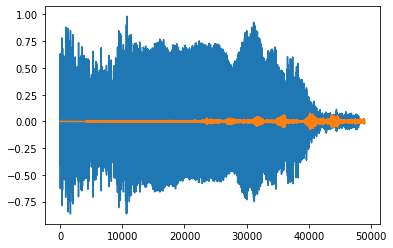

In [14]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

### from the above the blue one is the Cbird and orange line is not cbird

## here we create the np array to spectrogram
## means we make the audio to an image so that later we acn use image classification to classify the image

## create tensorflow dataset

### define paths to postive (Cbird) and negative data (non Cbird)

In [15]:
POS=f"/content/drive/MyDrive/audiorecognintion/data/Parsed_Capuchinbird_Clips"
NEG=f"/content/drive/MyDrive/audiorecognintion/data/Parsed_Not_Capuchinbird_Clips"

## create  tensorflow  datasets

In [16]:
pos=tf.data.Dataset.list_files(POS+"/*.wav")
neg=tf.data.Dataset.list_files(NEG+"/*.wav")

### here the .list_files jst goes inside the given directory and looks for a specific format of file like in this case .wav

In [17]:
pos.as_numpy_iterator().next()   # so this is like a iterator goes through the collected files and .next() everytime when we run it ,it gives the next file

b'/content/drive/MyDrive/audiorecognintion/data/Parsed_Capuchinbird_Clips/XC600460-3.wav'

## Add labels and combine positive and negative samples

In [18]:
len(pos)

217

## 1- Cbird  0- Not Cbird

In [19]:
positives=tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))  #this is to mark that each of this files is a Cbirds
negatives=tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))   #this is also to mark that these files are not Cbirds
data=positives.concatenate(negatives)  #here we are gonna combine all the data like the postive file and negative files with their marking to form a data

i think the __.as_numpy_iterator().next()__ is usually used to travers the files

In [20]:
# positives=tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
# positives.as_numpy_iterator().next()
# (b'/content/drive/MyDrive/audiorecognintion/data/Parsed_Capuchinbird_Clips/XC227471-6.wav',
#  1.0)  so here u can see not only the file but also it is been marked that it is a Cbird file

In [21]:
# negatives=tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
# negatives.as_numpy_iterator().next()
# (b'/content/drive/MyDrive/audiorecognintion/data/Parsed_Not_Capuchinbird_Clips/rain-thunder-and-crickets-sound-effect-38.wav',
#  0.0)  here u can see the file and it is been marked 0 indicating that it is not Cbird file

In [22]:
# data.shuffle(1000).as_numpy_iterator().next()    #here shuffle is used to shuffle the data

here in the above u can see that all the data is stored in one data pipeline that is the data variable


## data analysis part

## determine average length of a capuchin call

### calculate wave cycle lenght

In [23]:
CBIRD_PATH="/content/drive/MyDrive/audiorecognintion/data/Parsed_Capuchinbird_Clips"
NCBIRD_PATH="/content/drive/MyDrive/audiorecognintion/data/Parsed_Not_Capuchinbird_Clips"

In [24]:
lenght=[]

In [25]:

for file in os.listdir(CBIRD_PATH):  #this contains all the cbird file in this is the path to that directory
    tensor_wave=load_wav_16k_mono(POS+"/"+file)  #here the directory path is same for each file so for every new  file we concatenate its path with the directory path and find the lenght
    lenght.append(len(tensor_wave))


In [26]:
lenght  #we have different file lenghts

[56000,
 48000,
 56000,
 64000,
 40000,
 48000,
 64000,
 64000,
 64000,
 40000,
 64000,
 56000,
 64000,
 48000,
 56000,
 56000,
 56000,
 64000,
 48000,
 56000,
 64000,
 56000,
 48000,
 56000,
 64000,
 64000,
 56000,
 64000,
 56000,
 56000,
 56000,
 56000,
 64000,
 64000,
 48000,
 56000,
 48000,
 56000,
 64000,
 40000,
 56000,
 48000,
 40000,
 32000,
 64000,
 48000,
 56000,
 48000,
 48000,
 56000,
 48000,
 40000,
 56000,
 48000,
 64000,
 56000,
 40000,
 48000,
 64000,
 48000,
 72000,
 40000,
 64000,
 48000,
 40000,
 48000,
 56000,
 48000,
 48000,
 56000,
 64000,
 56000,
 56000,
 64000,
 56000,
 40000,
 56000,
 56000,
 56000,
 56000,
 48000,
 48000,
 56000,
 56000,
 56000,
 64000,
 40000,
 56000,
 64000,
 48000,
 48000,
 56000,
 64000,
 64000,
 48000,
 64000,
 48000,
 48000,
 48000,
 48000,
 56000,
 56000,
 64000,
 48000,
 48000,
 56000,
 64000,
 40000,
 48000,
 56000,
 64000,
 48000,
 56000,
 56000,
 56000,
 56000,
 56000,
 32000,
 64000,
 55999,
 56000,
 48000,
 48000,
 55999,
 40000,


### calculate the mean min max

In [27]:
54156/16000

#on average our cbird clips will be 3.38475

3.38475

In [28]:
tf.math.reduce_mean(lenght)  #calculate the mean

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [29]:
tf.math.reduce_min(lenght)  #calculat the min

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [30]:
tf.math.reduce_max(lenght) #for calculating the max


<tf.Tensor: shape=(), dtype=int32, numpy=80000>

we will grab the 40000 ish type of instance because if we train on the higher lenght spectrogram then the model takes lot of time to train and latency will be high 

## build preprocessing function to convert to spectrogram

### build preprocessing function

In [31]:
#this function is used to convert the given audio file to spectrogram
def preprocess(file_path,label):
  #load the data and processing to 16hz 
  wav=load_wav_16k_mono(file_path)
  #then we take the first 48000 examples
  wav=wav[:48000]
  #since we need 48000 all the clips most of the clips dnt
  # meet the requirement of 48000 some are less so we add extra zeros to make them achive that lenght
  zero_padding=tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
  wav=tf.concat([zero_padding,wav],0)
  
  #here we are creating the spectrogram
  spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32)  #this is the inbulit function for that   #this is sample rate==>frame_step=32
  spectrogram=tf.abs(spectrogram)  #everything here will become a postive example
  spectrogram=tf.expand_dims(spectrogram,axis=2)  #here we are expanding the dimension  #this encapsulates the spectrogram in another raise so it is in appropriate formate
  return spectrogram,label

In [32]:
wav=load_wav_16k_mono(CAPUHIN_FILE)
wav=wav[:48000]
zero_padding=tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
wav=tf.concat([zero_padding,wav],0)
wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 8.9910554e-07, -2.7947258e-06,  7.0741157e-06, ...,
       -1.0823049e-02, -3.5766482e-03,  1.5143131e-02], dtype=float32)>

In [33]:
spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
spectrogram=tf.abs(spectrogram)
spectrogram=tf.expand_dims(spectrogram,axis=2)  #this here adds a channel  #this is like processing a gray scaled image

In [34]:
spectrogram  #shape=(1491, 257, 1) a channel is been added  #this channel is added because a convolution nn needs a channel to process

#here 1 means it is a gray scale image as it has one channel

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[7.25913644e-02],
        [7.10330531e-02],
        [6.97736368e-02],
        ...,
        [4.76465182e-04],
        [2.46995420e-04],
        [7.33137131e-06]],

       [[3.56648862e-03],
        [9.92665999e-04],
        [5.69074415e-03],
        ...,
        [3.89362685e-04],
        [1.96771347e-04],
        [3.31550837e-05]],

       [[3.76079977e-03],
        [2.74862791e-03],
        [3.54933785e-03],
        ...,
        [3.23321641e-04],
        [2.26509219e-04],
        [4.48077917e-05]],

       ...,

       [[5.86301833e-03],
        [8.90618097e-03],
        [1.50155481e-02],
        ...,
        [7.96053617e-04],
        [3.32766504e-04],
        [1.28917396e-04]],

       [[3.70551646e-03],
        [6.76805852e-03],
        [1.34907337e-02],
        ...,
        [7.47070473e-04],
        [4.19661519e-04],
        [2.72586942e-04]],

       [[6.53017312e-04],
        [3.54314479e-03],
        [1.09438235e-02]

## test out the function and vis the spectrogram

this is a postive

In [35]:
filepath,label=positives.shuffle(10000).as_numpy_iterator().next()  #here we are gonna get back the file path and the corresponding label 0 or 1 in this case 1

In [36]:
spectrogram,label=preprocess(filepath,label)

In [37]:
spectrogram #this is nothing but the audio converted to an np array and it has one channel that is gray scale remember
#in the output you can see it did not meet the 48000 requirment so it is been padded with zeros

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[2.5458866e-01],
        [2.2620949e-01],
        [2.5109529e-01],
        ...,
        [5.1241904e-04],
        [3.9006904e-04],
        [3.8886070e-04]],

       [[1.5873596e-02],
        [2.8748408e-01],
        [5.3031915e-01],
        ...,
        [2.5702317e-04],
        [2.1436266e-04],
        [2.8814375e-04]],

       [[2.5713691e-01],
        [4.5891321e-01],
        [7.7743530e-01],
        ...,
        [2.5172369e-04],
        [1.7388017e-04],
        [8.5026026e-05]],

       ...,

       [[1.9675937e+00],
        [2.2028859e+00],
        [2.4875379e+00],
        ...,
        [3.3932566e-04],
        [9.4236137e-05],
        [7.3492527e-05]],

       [[1.5168641e+00],
        [2.0062199e+00],
        [2.2419171e+00],
        ...,
        [3.5497826e-04],
        [1.6910938e-04],
        [1.8948317e-04]],

       [[3.9546078e-01],
        [1.7490491e+00],
        [1.9166043e+00],
        ...,
        [5.4889813

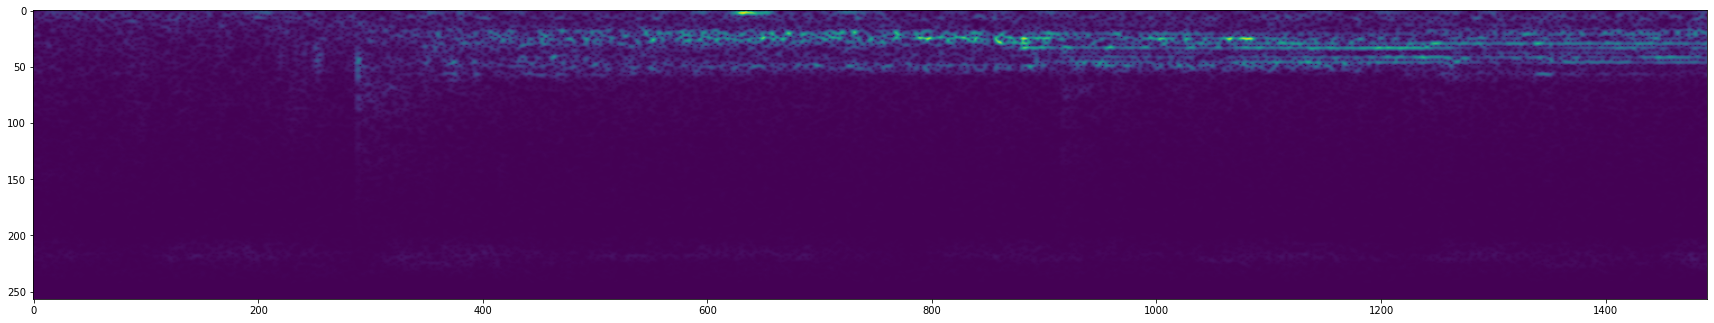

In [38]:
#visulize this
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

lets see this for a negative example

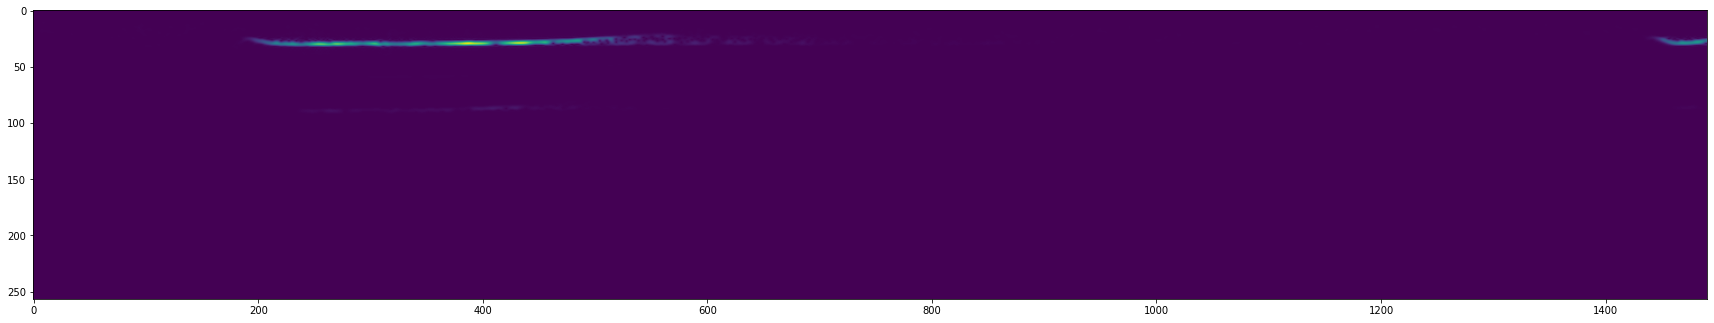

In [39]:
filepath,label=negatives.shuffle(10000).as_numpy_iterator().next()
spectrogram,label=preprocess(filepath,label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## here we will create a model

### creating training and testing partions

### create a tensorflow data pipeline

In [40]:
#here we are gonna map,cache,shuffle,batch,prefetch 
#using the api tf.data.Dataset api

In [41]:
data.as_numpy_iterator().next() 
# here it is still a string we need to add the actual file

(b'/content/drive/MyDrive/audiorecognintion/data/Parsed_Capuchinbird_Clips/XC46077-1.wav',
 1.0)

In [42]:
data=data.map(preprocess)  #like we are mappin the function so that  our string file path  has to go through that function
data=data.cache()
data=data.shuffle(buffer_size=1000)  #mixing 1 and 0  example 
data=data.batch(16) #we are make 16 batches of the total example and train them everytime
data=data.prefetch(8)  #eliminates cpu bottel necking


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### spliting into training and testing

In [43]:
len(data)*.7  #so total data is around 51 examples we are gonna take 70% for training tat is  36 for train and rest for test

35.699999999999996

In [44]:
train=data.take(36) #for training take first 36
test=data.skip(36).take(15)  #skip the first 36 and then last 15

### test one batch

In [45]:
samples,labels=train.as_numpy_iterator().next()

In [46]:
samples.shape
#(16, 1491, 257, 1) here we have 16 examples and each examples has the pixels 1491 x 257 and since it is a gray scale image has a channel 1

(16, 1491, 257, 1)

In [47]:
labels.shape

(16,)

# building the deep learning model

### load the dependencies

In [48]:
import tensorflow

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten,MaxPool2D

## build sequential model comile and view summary

In [50]:
model=Sequential([
    Conv2D(16,(3,3),activation="relu",input_shape=(1491,257,1)),
    MaxPool2D(pool_size=(3,3)),
    Conv2D(16,(3,3),activation="relu"),
    MaxPool2D(pool_size=(3,3)),
    Flatten(),  #we take the output from the conv2d which will be 3d and flatten it to 1d
    Dense(100,activation="relu"),
    Dense(1,activation="sigmoid")
])

Conv2D(16,(3,3),activation="relu",input_shape=(1491,257,1))<br>
so this above let me explain what is going on in this code<br>
16:- we want 16 different kernal or filter<br>
(3,3) of size 3 x 3<br>
activation function relu<br>
input_shape=(1491,257,1) thes means what ever input image we are giving we need it to match the given constrain

## imp note if u change the input shape of the spectrogram we need to change the how big we want the size of the wave in this case we had passed 48000 or we have to change this (wav,frame_length=320,frame_step=32) 

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 496, 85, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 494, 83, 16)       2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 164, 27, 16)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 70848)             0         
                                                                 
 dense (Dense)               (None, 100)               7

## fit model to train

In [53]:
hist=model.fit(train,epochs=4,validation_data=test)

Epoch 1/4
36/36 [==============================] - 16s 101ms/step - loss: 0.8897 - recall: 0.7911 - precision: 0.8117 - val_loss: 0.1224 - val_recall: 0.8929 - val_precision: 0.9259
Epoch 2/4
36/36 [==============================] - 2s 66ms/step - loss: 0.0648 - recall: 0.9518 - precision: 0.9753 - val_loss: 0.0469 - val_recall: 0.9412 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 2s 65ms/step - loss: 0.0290 - recall: 0.9875 - precision: 0.9875 - val_loss: 0.0103 - val_recall: 0.9821 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 2s 66ms/step - loss: 0.0089 - recall: 0.9933 - precision: 1.0000 - val_loss: 0.0137 - val_recall: 1.0000 - val_precision: 1.0000


### lets plot the loss

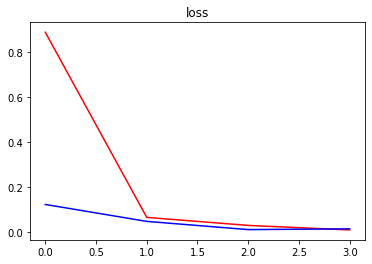

In [54]:
plt.title("loss")
plt.plot(hist.history["loss"],"r")
plt.plot(hist.history["val_loss"],"b")
plt.show()

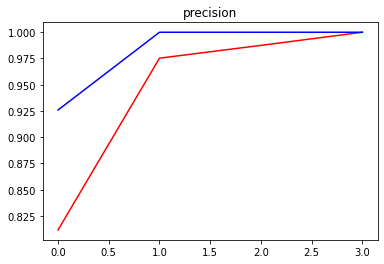

In [58]:
hist.history
plt.title("precision")
plt.plot(hist.history["precision"],"r")  
plt.plot(hist.history["val_precision"],"b")
plt.show()

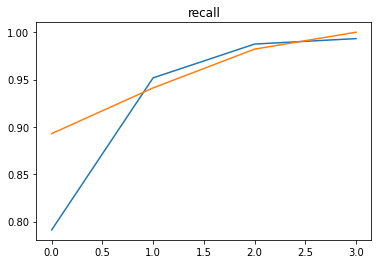

In [59]:
plt.title("recall")
plt.plot(hist.history["recall"])
plt.plot(hist.history["val_recall"])
plt.show()

## make prediction

### get one batch and make a prediction

In [60]:
x_test,y_test=test.as_numpy_iterator().next()  # here it will return the sample and the corresponding label

In [61]:
x_test.shape

(16, 1491, 257, 1)

In [62]:
yhat=model.predict(x_test)

1/1 [==============================] - 0s 123ms/step


In [63]:
yhat.shape

(16, 1)

above we have jst the bunch of probability for 16 example of one batch as we have passed it through sigmoid it will jst give the probability between 0 -1 

## convert the logits to classesn (means we are setting a threshold thats it like 0.5 and passig the value of yhat if the value is >=0.5 then it is 1 if not 0 yhat value

In [66]:
yhat=[1 if prediction>=0.5 else 0 for prediction in yhat]

In [67]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [68]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [69]:
yhat

[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]

In [70]:
y_test

array([0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [71]:
#converting the y_test float to int using .astype(int)
y_test.astype(int)

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0])

## bulid forest parsing functions

### load up the long mp3 clips 

tf.math.reduce_sum() is a function in TensorFlow that computes the sum of all elements along the specified axes of a tensor

In [72]:
FOREST_PATH="/content/drive/MyDrive/audiorecognintion/data/Forest Recordings"

In [77]:
def load_mp3_16k_mono(filename):
  """load a wav file,convert it to a float tensor ,resample to 16 khz single"""
  res=tfio.audio.AudioIOTensor(filename) #this will take our mp3 file and load them 
  #convert to tensor and combine channels
  tensor=res.to_tensor()                           #here each file is a multichannel so instead of dropping the channel we take the tensor and added it together and we takea average
  tensor=tf.math.reduce_sum(tensor,axis=1)/2
 #extract sample rate and caste
  sample_rate=res.rate
  sample_rate=tf.cast(sample_rate,dtype=tf.int64)
  #resample to 16 hz
  wav=tfio.audio.resample(tensor,rate_in=sample_rate,rate_out=16000)
  return wav

In [78]:
one_file=FOREST_PATH+"/"+"recording_00.mp3"

In [81]:
wav=load_mp3_16k_mono(one_file)
wav

<tf.Tensor: shape=(2880666,), dtype=float32, numpy=
array([ 8.1433272e-12, -5.7019250e-12, -5.3486417e-12, ...,
       -1.1291276e-02, -1.4230422e-02, -3.0555837e-03], dtype=float32)>

### below we are gonna take the big wav file and convert to audio slices <br>
### instead of taking one massive clip and make prediction we are gonna make some slice of size same as the one  we used to train our model<br>
### we are gonna make multiple prediction on the same clip

In [82]:
audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)

here tf.keras.utils.timeseries_dataset_from_array() this funcion is gonna make the slices of that big wav file

In [83]:
samples,index=audio_slices.as_numpy_iterator().next()

In [85]:
samples.shape

(1, 48000)

In [87]:
len(audio_slices)  #60 here we had taken 1 clips and make them as 60 different windows like small small clips of 60 of range 48000

60

## build a function to convert clips into windowed spectrograms

In [103]:
def preprocess_mp3(sample,index):
  sample=sample[0]
  zero_padding=tf.zeros([48000]-tf.shape(sample),dtype=tf.float32)
  wav=tf.concat([zero_padding,sample],0)
  spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
  spectrogram=tf.abs(spectrogram)
  spectrogram=tf.expand_dims(spectrogram,axis=2)
  return spectrogram


### convert longer clips into windows and make prediction

In [104]:
audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)
audio_slices=audio_slices.map(preprocess_mp3)
audio_slices=audio_slices.batch(64)

In [112]:
yhat=model.predict(audio_slices)
yhat=[1 if pred>=0.99 else 0 for pred in yhat]

1/1 [==============================] - 1s 1s/step


In [113]:
yhat

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

### group consecutive detection

In [114]:
from itertools import groupby

In [122]:
tf.math.reduce_sum(yhat).numpy()  #<tf.Tensor: shape=(), dtype=int32, numpy=5> in this the numpy is the important value to foucus the value in it the number of bird calls

5

## make predictions

### loop over all recording and make predictions

In [125]:
results={} #empty dictonary
for file in os.listdir(FOREST_PATH):
  FILEPATH=FOREST_PATH+"/"+file
  # print(FILEPATH)
  wav=load_mp3_16k_mono(FILEPATH)
  audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)
  audio_slices=audio_slices.map(preprocess_mp3)
  audio_slices=audio_slices.batch(64)

  yhat=model.predict(audio_slices)

  results[file]=yhat

1/1 [==============================] - 1s 1s/step


In [127]:
type(results)

dict

## now we will convert all the probability from the sigmoid to classes like 1 or 0 by setting up the threshold

In [129]:
class_preds={} #an empty dictonary
for file,logits in results.items():
  class_preds[file]=[1 if p>=0.99 else 0 for p in logits]

class_preds


{'recording_06.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_09.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_04.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

## group consecutive detections

In [131]:
postprocess={} #empty dictonary
for file,scores in class_preds.items():
  postprocess[file]=tf.math.reduce_sum([key for key,group in groupby(scores)]).numpy()

postprocess


{'recording_06.mp3': 5,
 'recording_09.mp3': 0,
 'recording_04.mp3': 4,
 'recording_03.mp3': 0,
 'recording_10.mp3': 5,
 'recording_07.mp3': 2,
 'recording_05.mp3': 0,
 'recording_01.mp3': 0,
 'recording_08.mp3': 20,
 'recording_00.mp3': 5,
 'recording_02.mp3': 0,
 'recording_29.mp3': 0,
 'recording_24.mp3': 0,
 'recording_21.mp3': 1,
 'recording_15.mp3': 2,
 'recording_16.mp3': 6,
 'recording_19.mp3': 4,
 'recording_27.mp3': 0,
 'recording_18.mp3': 4,
 'recording_22.mp3': 2,
 'recording_13.mp3': 0,
 'recording_11.mp3': 4,
 'recording_20.mp3': 0,
 'recording_28.mp3': 11,
 'recording_26.mp3': 2,
 'recording_12.mp3': 1,
 'recording_17.mp3': 8,
 'recording_14.mp3': 0,
 'recording_25.mp3': 10,
 'recording_23.mp3': 6,
 'recording_35.mp3': 0,
 'recording_31.mp3': 1,
 'recording_45.mp3': 3,
 'recording_30.mp3': 3,
 'recording_44.mp3': 1,
 'recording_36.mp3': 0,
 'recording_33.mp3': 0,
 'recording_37.mp3': 3,
 'recording_39.mp3': 3,
 'recording_41.mp3': 0,
 'recording_46.mp3': 6,
 'recording_3

### export the results to csv

In [132]:
import csv

In [135]:
with open("results.csv","w",newline="") as f:
  writer=csv.writer(f,delimiter=",")
  writer.writerow(["recording","Cbird_calls"])
  for key,value in postprocess.items():
    writer.writerow([key,value])